In [ ]:
###########################################################
# Purpose: Create a set of random forest models Using     #
# molecular fingerprints to classify chemicals as skin    #
# sensitizers or not                                      #
###########################################################
 

# General data processing libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# random forest and metrics
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, RocCurveDisplay

# chemistry libraries
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, DataStructs
from rdkit.Chem import AtomPairs, Draw
from rdkit.Chem.AtomPairs import Utils, Pairs




In [3]:
# load the data from a local folder

fpath = 'C:/Users/kdjanse/OneDrive - Rockline Industries/Desktop/DataSci_Programs/DS Capstone/DataSets/df_skinsens.csv'
df_skinsens = pd.read_csv(fpath)

In [4]:
# a mol file is an RDKit object that is used to create the mol image and used as input for various operations in RDKit

# create a column of mol files from the SMILES
df_skinsens['mols'] = [Chem.MolFromSmiles(smile) for smile in df_skinsens['canonicalsmiles']]


# drop three rows that don't have a valid mol
df_skinsens = df_skinsens.dropna(subset=['mols'])

## use RDKit to construct the fingerprints ##

# morgan fingerprint (ECFP4)
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
df_morgan = np.array([mfpgen.GetFingerprint(mol) for mol in df_skinsens['mols']])
#print(df_morgan.shape)

# rdkit fingerprint
rdkfpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=1024)
df_rdkit = np.array([rdkfpgen.GetFingerprint(mol) for mol in df_skinsens['mols']])

# atom pairs fingerprint
apfpgen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=1024)
df_ap = np.array([apfpgen.GetFingerprint(mol) for mol in df_skinsens['mols']])

# topological torsion fingerprints
topofpgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=1024)
df_topo = np.array([topofpgen.GetFingerprint(mol) for mol in df_skinsens['mols']])

# all fingerprints combined
df_allfp = np.hstack((df_morgan, df_rdkit, df_ap, df_topo))

# the output will show  
# WARNING: not removing hydrogen atom without neighbors
# Explicit valence for atom # 1 Si, 8, is greater than permitted 
# These comments will not cause problems

[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not removing hydrogen atom without neighbors
[09:39:39] WARNING: not r

In [40]:
# function to run the random forest classifier
def rf_classifier(fp_type, n_est):
  '''
  run the random forest classifier given a fingerprint type and number of estimators
  output: display of performance metrics from the test set
  and a dictionary of performance metrics
  
  '''
  fp_dict = {'morgan':df_morgan, 'ap':df_ap, 'rdk': df_rdkit, 'topo':df_topo, 'all': df_allfp}
  
  fp_df = fp_dict[fp_type]
  
  X = fp_df
  y = df_skinsens['sensitizer']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1973)
  forest = RandomForestClassifier(n_estimators= n_est, n_jobs=-1, random_state=0, verbose=0, class_weight= {0:1.5, 1:1}) #class weights added to favor recall
  rf_model = forest.fit(X_train, y_train)
  pred = forest.predict(X_test)
  
  #variable importance 
  importances = forest.feature_importances_

  # metrics
  f1 = f1_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  cf_test = confusion_matrix(y_test, pred)
  
  # output
  rfdict = {'FP_type': fp_df, 'Num_estimators': n_est, 'F1_score':f1, 'Accuracy':accuracy, 'Confusion matrix':cf_test,
  'Precision': precision, 'Recall':recall, 'importances': importances, 'trainFP': X_train, 'trainSens':y_train}
  print(f"FP_type: {fp_type.upper()}    Num_estimators: {n_est}   F1: {rfdict.get('F1_score'):.4}   Accuracy: {rfdict.get('Accuracy'):.4}   Precision: {rfdict.get('Precision'):.4}  Recall: {rfdict.get('Recall'):.4}\n")
  
  return rfdict


In [41]:
morg_dict = rf_classifier('morgan', 500)
ap_dict = rf_classifier('ap', 500)
rdk_dict = rf_classifier('rdk', 500)
topo_dict = rf_classifier('topo', 500)
allfp_dict = rf_classifier('all',500)

FP_type: MORGAN    Num_estimators: 500   F1: 0.7775   Accuracy: 0.7864   Precision: 0.8079  Recall: 0.7494

FP_type: AP    Num_estimators: 500   F1: 0.7824   Accuracy: 0.7866   Precision: 0.795  Recall: 0.7702

FP_type: RDK    Num_estimators: 500   F1: 0.7808   Accuracy: 0.792   Precision: 0.8219  Recall: 0.7435

FP_type: TOPO    Num_estimators: 500   F1: 0.7684   Accuracy: 0.7762   Precision: 0.7931  Recall: 0.7452

FP_type: ALL    Num_estimators: 500   F1: 0.7867   Accuracy: 0.7951   Precision: 0.817  Recall: 0.7585



In [42]:
ap_dict['Confusion matrix']

array([[1943,  477],
       [ 552, 1850]], dtype=int64)

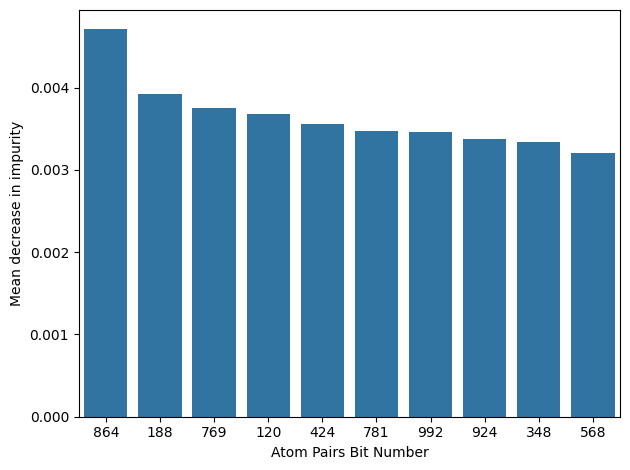

In [7]:
# feature importance from sklearn
# atom pairs
feat_df = pd.DataFrame.from_dict(ap_dict['importances'])
feat_dfreset = feat_df.reset_index().rename(columns = {'index':'FP_bit', 0:'Importance'})
feat_sorted = feat_dfreset.sort_values(by = 'Importance', ascending = False).reset_index().head(10)

#plotting feature importance
fig, ax = plt.subplots()

sns.barplot(data=feat_sorted, x= 'FP_bit',y='Importance', order= feat_sorted.sort_values('Importance', ascending= False).FP_bit)
#ax.set_title("RDKit Feature importances")
ax.set_xlabel("Atom Pairs Bit Number")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [8]:
# exploring which chemicals had the top bits
bitlst = [864, 188, 769, 120, 424, 781, 992, 924, 348, 568] # top 10 bits in ap_fp

matching_rows = [idx for idx in range(df_ap.shape[0]) if np.all(df_ap[idx, bitlst] != 0)]
print(matching_rows)
len(matching_rows)

[75, 91, 159, 175, 219, 894, 895, 1343, 1347, 1501, 1503, 1509, 1516, 1519, 1540, 1541, 1546, 1734, 1741, 1762, 1894, 1985, 2271, 2869, 3132, 3289, 3345, 3423, 3434, 3481, 3482, 3483, 3485, 3487, 3496, 3631, 3677, 3679, 3687, 4172, 4182, 4187, 4195, 4228, 4243, 4537, 5251, 5320, 5342, 5675, 5816, 5884, 5935, 5945, 5951, 5953, 5957, 6009, 6017, 6038, 6181, 6223, 6225, 6229, 6232, 6240, 6261, 6271, 6272, 6294, 6312, 6389, 6402, 6404, 6433, 6451, 6459, 6460, 6492, 6527, 6534, 6549, 6553, 6554, 6558, 6568, 6641, 6674, 6680, 6830, 6849, 6986, 7182, 7206, 7275, 7908, 7915, 7916, 7924, 7928, 8095, 8099, 8100, 8104, 8111, 8112, 8250, 8251, 8278, 8321, 8497, 8500, 8512, 8513, 8515, 8516, 8517, 8518, 8519, 8520, 8522, 8524, 8525, 8682, 8718, 8728, 8914, 8957, 8967, 8974, 9028, 9062, 9074, 9140, 9145, 9212, 9213, 9230, 9246, 9285, 9355, 9358, 9407, 9422, 9429, 9462, 9463, 9581, 9607, 9634, 9654, 9759, 9767, 9792, 9816, 9818, 9826, 9840, 9928, 9960, 9989, 10027, 10034, 10099, 10121, 10146, 10161, 

423

In [9]:
ex_df=df_skinsens.loc[matching_rows]
exmpl = df_skinsens.loc[1734]['mols']


ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()

# atom pairs fingerprint
apfpgen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=1024)
apfp = apfpgen.GetFingerprint(exmpl, additionalOutput = ao)
bi = ao.GetBitInfoMap()

# this is a dictionary of atom pairs of each bit
bi




{0: ((1, 10),
  (6, 60),
  (10, 17),
  (14, 20),
  (14, 42),
  (14, 43),
  (17, 62),
  (18, 49),
  (26, 59),
  (29, 58),
  (32, 49),
  (34, 49),
  (39, 49),
  (41, 54),
  (42, 54)),
 1: ((1, 10),
  (6, 60),
  (10, 17),
  (14, 20),
  (14, 42),
  (14, 43),
  (17, 62),
  (18, 49),
  (26, 59),
  (29, 58),
  (32, 49),
  (34, 49),
  (39, 49),
  (41, 54),
  (42, 54)),
 2: ((1, 10),
  (6, 60),
  (10, 17),
  (14, 20),
  (14, 42),
  (14, 43),
  (17, 62),
  (18, 49),
  (26, 59),
  (29, 58),
  (32, 49),
  (34, 49),
  (39, 49),
  (41, 54),
  (42, 54)),
 3: ((1, 10),
  (6, 60),
  (10, 17),
  (14, 20),
  (14, 42),
  (14, 43),
  (17, 62),
  (18, 49),
  (26, 59),
  (29, 58),
  (32, 49),
  (34, 49),
  (39, 49),
  (41, 54),
  (42, 54)),
 4: ((1, 9),
  (5, 60),
  (9, 17),
  (13, 20),
  (13, 42),
  (13, 43),
  (17, 56),
  (17, 61),
  (20, 30),
  (22, 53),
  (26, 45),
  (28, 57),
  (30, 61),
  (38, 49),
  (41, 53),
  (42, 53),
  (46, 66)),
 5: ((1, 9),
  (5, 60),
  (9, 17),
  (13, 20),
  (13, 42),
  (13, 43

In [12]:
bit864 = [2,28]

img = Draw.MolToImage(
    exmpl, 
    highlightAtoms = bit864,
    #highlightBonds = highlighted_bonds,
    highlightColor = (0, 0.1, 0.1, 0.6),
    size = (850,400))

img.show()

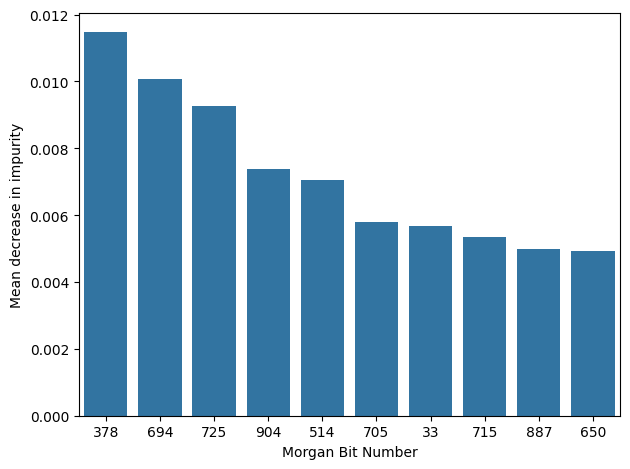

In [11]:
# feature importance from sklearn
# morgan
feat_df = pd.DataFrame.from_dict(morg_dict['importances'])
feat_dfreset = feat_df.reset_index().rename(columns = {'index':'FP_bit', 0:'Importance'})
feat_sorted = feat_dfreset.sort_values(by = 'Importance', ascending = False).reset_index().head(10)

#plotting feature importance
fig, ax = plt.subplots()

sns.barplot(data=feat_sorted, x= 'FP_bit',y='Importance', order= feat_sorted.sort_values('Importance', ascending= False).FP_bit)
#ax.set_title("RDKit Feature importances")
ax.set_xlabel("Morgan Bit Number")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [38]:
# how many chemicals in the data set had morgan bits 378, 694, 725, 904, 514, 705, 33, 715, 887, 650

# exploring which chemicals had the top bits
morg_bitlst = [378, 694, 725, 904, 514, 705, 33, 715, 887, 650] # top 10 bits in morg_fp

morg_matching_rows = [idx for idx in range(df_morgan.shape[0]) if (df_morgan[idx, morg_bitlst[0]] != 0)]
print(morg_matching_rows)
len(morg_matching_rows)

[26, 42, 44, 47, 54, 62, 70, 72, 73, 75, 82, 91, 92, 93, 94, 95, 96, 97, 99, 100, 102, 106, 118, 145, 146, 155, 156, 157, 160, 174, 178, 183, 197, 203, 217, 218, 220, 222, 223, 224, 225, 226, 227, 228, 229, 231, 233, 235, 244, 251, 255, 277, 278, 281, 284, 285, 290, 303, 322, 333, 347, 400, 401, 402, 403, 404, 405, 411, 435, 440, 441, 446, 455, 459, 478, 481, 493, 527, 528, 576, 595, 631, 645, 646, 655, 657, 684, 698, 721, 743, 746, 804, 808, 818, 829, 839, 840, 841, 847, 852, 853, 868, 869, 875, 920, 922, 923, 936, 945, 946, 963, 981, 990, 992, 994, 1016, 1032, 1065, 1080, 1083, 1098, 1107, 1120, 1123, 1126, 1139, 1148, 1159, 1178, 1203, 1212, 1273, 1279, 1283, 1313, 1320, 1330, 1335, 1356, 1357, 1372, 1373, 1402, 1403, 1404, 1408, 1423, 1427, 1439, 1450, 1465, 1467, 1468, 1471, 1491, 1492, 1495, 1497, 1500, 1501, 1503, 1509, 1513, 1515, 1516, 1519, 1522, 1525, 1529, 1530, 1531, 1536, 1537, 1540, 1541, 1546, 1547, 1549, 1550, 1552, 1555, 1556, 1559, 1562, 1563, 1566, 1602, 1620, 1666,

5787

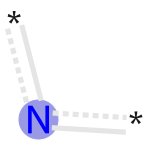

In [39]:
exmpl = df_skinsens.loc[26]['mols']


ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()

# morgan fingerprint (ECFP4)
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
morganfp = mfpgen.GetFingerprint(exmpl, additionalOutput = ao)

bi = ao.GetBitInfoMap()
# 'bi' is a dictionary of key: bit & value: bit info (tuple) of the start and end atoms from ao.CollectBitInfoMap()


# create an image of the Morgan Bit
Draw.DrawMorganBit(exmpl, 378, bi, useSVG=True)
